In [1]:
cd /home/yuchen/pulse2percept

/home/yuchen/pulse2percept


In [2]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
import shapes
import pandas as pd
import numpy as np
import pulse2percept
import matplotlib.pyplot as plt
from pulse2percept.stimuli import Stimulus
from pulse2percept.viz import plot_argus_simulated_phosphenes
from pulse2percept.viz import plot_argus_phosphenes
from pulse2percept.implants import ArgusII
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
from pulse2percept.viz import plot_argus_phosphenes
from pulse2percept.implants import ArgusII

In [3]:
df = pd.read_csv('/home/yuchen/shapes/estimator05xystep/axon.csv')
df = df[(df['subject'] == 's2') & ~df['test_orientation'].isna()]
df = df.sort_values(df.columns[0]).reset_index(drop=True)
df

electrode         rho    axlambda  train_combined  train_area  \
0         A1  162.797723  519.825241        3.449556    1.144632   
1        A10  147.314502  658.172940        3.577132    1.154698   
2         A2  152.228902  640.545078        3.602581    1.144869   
3         A4  151.731792  588.457795        3.594521    1.140455   
4         A6  153.731336  567.207942        3.582082    1.124235   
5         A8  158.298709  600.940771        3.577649    1.151908   
6         B1  160.833396  512.619857        3.511133    1.109275   
7         B3  153.830187  620.606502        3.557186    1.118929   
8         B9  176.401004  698.555459        3.626330    1.203610   
9         C1  151.996811  563.710263        3.565663    1.124472   
10       C10  163.325666  542.601994        3.580337    1.149034   
11        C4  131.796133  585.295249        3.537474    1.149370   
12        C7  155.243122  639.956374        3.569382    1.135766   
13        C8  155.852737  593.330449        3.562224    1.123242   
14        D1  146.229251  531.643241        3.574832    1.098680   
15       D10  147.354281  644.105743        3.557088    1.133517   
16        D4  159.706129  572.096037        3.525818    1.146440   
17        D6  156.034831  600.080930        3.604873    1.158031   
18        D7  131.462629  670.539824        3.625886    1.177738   
19        D8  166.168865  556.493817        3.545958    1.116055   
20        E1  153.393713  471.659369        4.086478    1.221358   
21       E10  159.826061  538.207213        3.558674    1.103254   
22        E3  150.208719  584.486686        3.575690    1.140890   
23        E7  156.600472  577.165495        3.587108    1.113132   
24        E9  147.506371  633.790247        3.592637    1.140548   
25        F2  160.677791  542.141145        3.561743    1.122111   
26        F4  159.828596  533.775836        3.565372    1.104635   
27        F6  152.919867  585.991663        3.555752    1.122483   
28        F7  137.341348  632.489234        3.363193    1.019756   
29        F9  161.564608  555.257285        3.574673    1.144780   

    train_MSE_major_axis_length  train_MSE_minor_axis_length  test_combined  \
0                      1.278803                     1.026121   1.005603e+04   
1                      1.400365                     1.022069   3.414340e+02   
2                      1.421897                     1.035815   4.748162e+01   
3                      1.428383                     1.025682   2.124297e+03   
4                      1.430844                     1.027004   1.884291e+02   
5                      1.406116                     1.019625   5.675545e+01   
6                      1.382854                     1.019004   1.215007e+02   
7                      1.403213                     1.035045   2.573069e+03   
8                      1.404101                     1.018620   4.384654e+01   
9                      1.402433                     1.038758   3.148054e+01   
10                     1.406102                     1.025201   1.850605e+02   
11                     1.353955                     1.034149   8.529528e+03   
12                     1.408494                     1.025123   1.196538e+02   
13                     1.397674                     1.041308   4.499186e+01   
14                     1.447379                     1.028772   1.184118e+06   
15                     1.393512                     1.030059   1.552324e+02   
16                     1.344132                     1.035246   7.141035e+03   
17                     1.415423                     1.031419   8.852864e+02   
18                     1.422443                     1.025706   2.693968e+01   
19                     1.399589                     1.030315   6.162793e+02   
20                     1.805113                     1.060007   2.064113e+01   
21                     1.429761                     1.025659   2.791092e+02   
22                     1.393088                     1.041712   2.133922e+03  

In [11]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.125

estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', "major_axis_length", "minor_axis_length"], loss_fn='r2', scale_features=False, resize=True)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=20, has_loss_function=True)

data = shapes.load_shapes("/home/yuchen/shapes/data/shapes.h5", subjects=['12-005'],stim_class=None)
data = data[data['electrode2'] == str()].reset_index(drop=True)
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

y_moments = estimator.compute_moments(y)
averaged_moments = data
averaged_moments[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = averaged_moments.groupby(['electrode1','amp1', 'freq','pdur'])['area', 'eccentricity', 'orientation'].mean()
x = averaged_moments.index.to_frame().reset_index(drop=True)

df_pred = pd.DataFrame()
for i in range(len(df)):
    electrode =  df.electrode[i]
    x_temp = x[x['electrode1']==electrode].reset_index(drop=True)
    df_temp = df[df['electrode']==electrode].reset_index(drop=True)
    
    # set estimator parameters and predict percepts for each leave-one-electrode-out cross validation group
    params = {'rho':df_temp.rho[0], 'axlambda':df_temp.axlambda[0]}
    estimator.set_params(**params)
    estimator.fit(x_temp,averaged_moments.loc[[(electrode)]])
    preds = estimator.predict(x_temp)
    df_pred = pd.concat([df_pred, preds], axis = 0)
x['pred']=df_pred.iloc[:, 0].tolist()

In [12]:
x

electrode1  amp1  freq  pdur  \
0           A1  1.25  20.0  0.45   
1           A1  1.50  20.0  0.45   
2           A1  2.00  20.0  0.45   
3          A10  1.50  20.0  0.45   
4          A10  2.00  20.0  0.45   
..         ...   ...   ...   ...   
105         F7  5.00  20.0  0.45   
106         F7  7.50  20.0  0.45   
107         F9  1.25  20.0  0.45   
108         F9  1.50  20.0  0.45   
109         F9  2.00  20.0  0.45   

                                                  pred  
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
..                                                 ...  
105  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
106  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
107  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
108  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
109  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[110 rows x 5 columns]

In [13]:
# construct dataframes
from pulse2percept.datasets import fetch_beyeler2019
data1 = fetch_beyeler2019(subjects='S2')
df_pred = pd.DataFrame({
    'subject':'S2',
    'image':x.pred,
    'electrode':x.electrode1
})
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
df_pred['xrange']=data1.xrange
df_pred['yrange']=data1.yrange
df_pred['amp'] = x.amp1
df_pred['freq']=x.freq
# for i in range(len(df_pred)):
#     df_pred['image'][i] = resize(center_image(x.pred[i] > (x.pred[i].max() - x.pred[i].min()) * 0.1 + x.pred[i].min()), y[i].shape)
    
df_actual = data[['subject','image','electrode1','amp1','freq']]
df_actual['subject'] = 'S2'
df_actual['xrange']=[(-30.0, 30.0)]*len(df_actual)
df_actual['yrange']=[(-22.5, 22.5)]*len(df_actual)
df_actual=df_actual.rename(columns={"electrode1": "electrode",'amp1':'amp'})

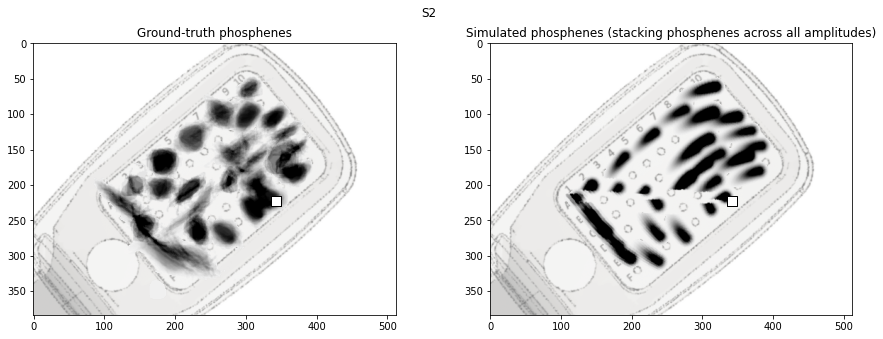

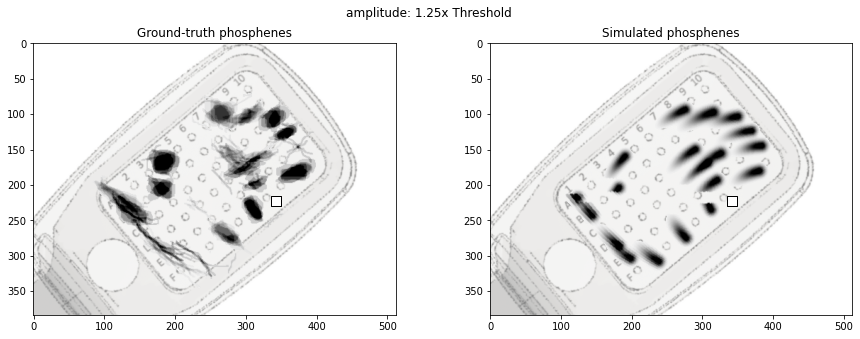

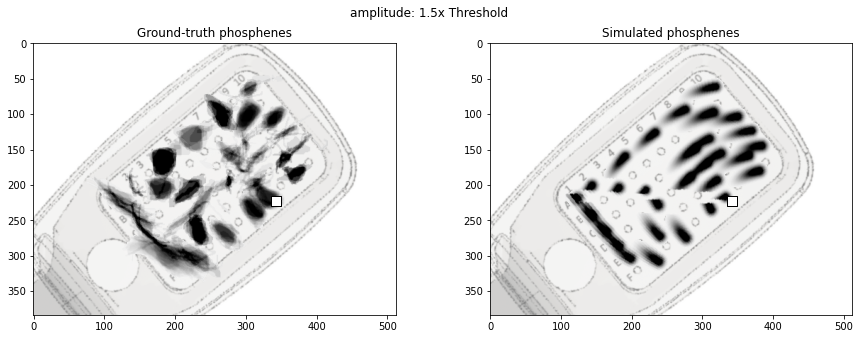

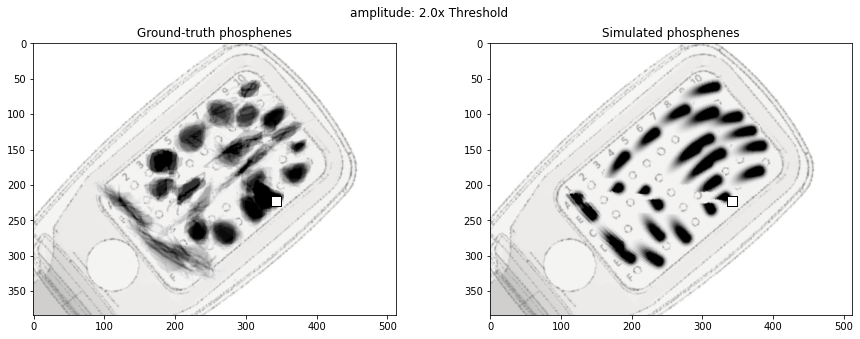

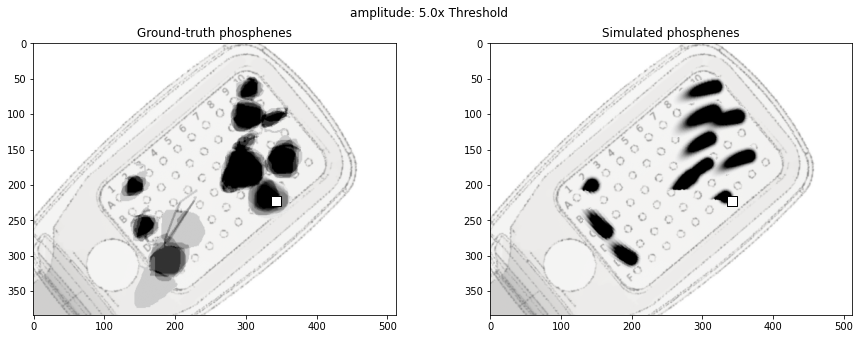

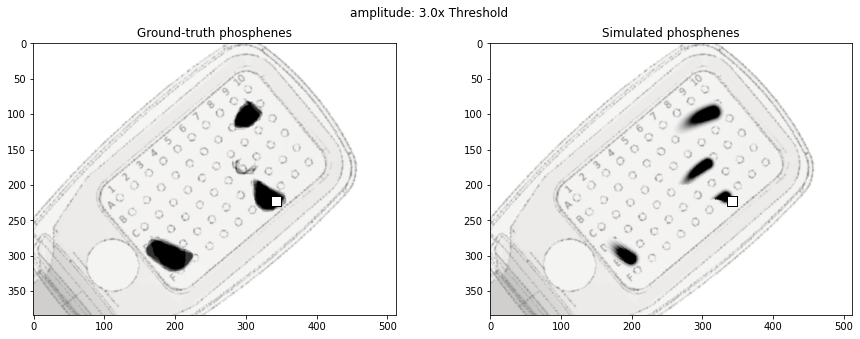

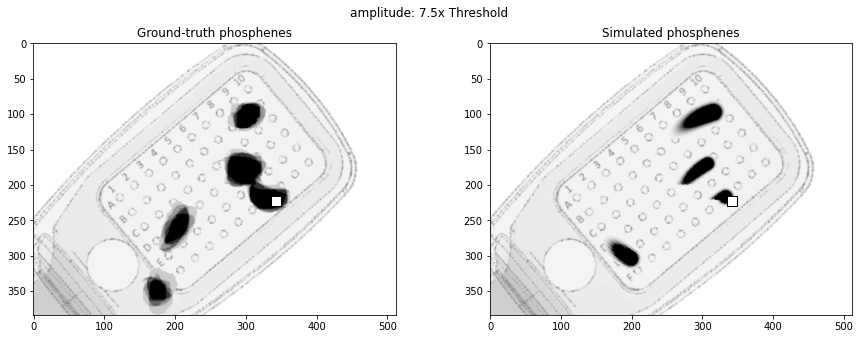

In [14]:
from pulse2percept.viz import plot_argus_phosphenes
from pulse2percept.implants import ArgusII
fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
argus = ArgusII(x=-1896, y =-542, rot=-44, eye='RE')
plot_argus_phosphenes(df_actual, argus, ax=ax_data,scale=1)
plot_argus_phosphenes(df_pred, argus,ax=ax_sim,scale=1)
ax_data.set_title('Ground-truth phosphenes')
ax_sim.set_title('Simulated phosphenes (stacking phosphenes across all amplitudes)')
fig.suptitle('S2')

for i in range(len(x.amp1.unique())):
    amp_temp=x.amp1.unique()[i]
    df_actual_temp=df_actual[df_actual['amp']==amp_temp]
    df_pred_temp=df_pred[df_pred['amp']==amp_temp]
    fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
    plot_argus_phosphenes(df_actual_temp, argus, ax=ax_data,scale=1)
    plot_argus_phosphenes(df_pred_temp, argus,ax=ax_sim,scale=1)
    ax_data.set_title('Ground-truth phosphenes')
    ax_sim.set_title('Simulated phosphenes')
    fig.suptitle('amplitude: ' + str(amp_temp) + 'x Threshold')

In [15]:
df = pd.read_csv('/home/yuchen/shapes/estimator05xystep/axon.csv')
df = df[(df['subject'] == 's3') & ~df['test_orientation'].isna()]
df = df.sort_values(df.columns[0]).reset_index(drop=True)
df

electrode        rho     axlambda  train_combined  train_area  \
0        A10  24.127473   682.706429        4.279871    1.078358   
1         A6  24.740524   814.153799        4.247466    1.046680   
2         B4  16.739050  1026.252759        3.643218    1.013230   
3         B9  24.990036   801.388422        4.248008    1.046551   
4        C10  10.000000  1107.498292        4.420554    1.127564   
5         C3  10.000000  1124.021573        4.188851    1.017298   
6         C5  25.027850   811.496888        3.821864    0.972539   
7         C6  24.675527   803.920134        4.367678    1.121986   
8         C8  10.000000  1106.406750        4.284885    1.005068   
9         D3  24.625370   818.206739        4.217373    1.063713   
10        D8  10.000000  1125.740510        4.376698    1.113882   
11        E1  23.854408   907.711991        5.049930    1.649924   
12        E2  23.934097   947.634395        6.120738    1.752155   
13        E9  10.000000  1042.101991        4.488607    1.318456   
14        F4  25.900357   703.885878        4.346769    1.058433   

    train_MSE_major_axis_length  train_MSE_minor_axis_length  test_combined  \
0                      2.056167                     1.145347   3.581797e+03   
1                      2.072718                     1.128068   2.108247e+02   
2                      1.515370                     1.114618   4.595713e+04   
3                      2.060271                     1.141186   1.114176e+03   
4                      2.083589                     1.209401   9.009908e+04   
5                      2.006557                     1.164996   3.295627e+03   
6                      1.815203                     1.034123   7.916824e+03   
7                      2.148897                     1.096796   4.688659e+06   
8                      2.153419                     1.126398   1.597223e+05   
9                      2.036874                     1.116786   6.545149e+04   
10                     2.177423                     1.085394   1.131749e+04   
11                     2.175106                     1.224900   1.328830e+03   
12                     2.310894                     2.057689   8.958099e+01   
13                     2.064904                     1.105247   5.007614e+04   
14                     2.139515                     1.148821   2.989742e+01   

       test_M00     test_M02  ...     test_M22   test_area  test_eccentricity  \
0      2.812130     6.800958  ...   145.951587    1.863342           1.012732   
1      4.249854     1.597153  ...   181.674477    4.637908           1.830319   
2      9.202804     1.956177  ...     1.481276   13.074286       45597.868279   
3     89.895853     2.287200  ...   531.454194  177.372050           1.001158   
4      7.104476    75.833189  ...     3.200241   14.677560       86036.314946   
5      3.297802     6.692823  ...     7.420774   10.515326        3198.653463   
6      3.851080     1.690607  ...     1.561703    6.164845        7878.955798   
7      1.106879     4.628328  ...     2.236983   19.256198           7.773452   
8      4.321087     2.700818  ...     2.373267    8.640121      159424.476288   
9      1.648484     1.079041  ...     1.710192    1.038457       30646.828541   
10     5.648448     9.192793  ...     3.473312    6.475594        7110.345748   
11     1.067449   235.177616  ...    26.074935    1.227476         894.156569   
12     2.220015     2.715388  ...     2.241804   15.312019          20.894332   
13  1574.326785  4410.458282  ...  1081.501646   21.725618       42761.356839   
14     1.085875     1.611231  ...     2.153506    1.107275           1.070222   

    test_major_axis_length  test_minor_axis_length  test_orientation  \
0                19.593552            1.852169e+01       1180.968127   
1                 1.000953            6.612073e+00          1.869699   
2                12.648045            3.503449e+00        311.300503   
3                 7.005135            1.722191e+01         24.08

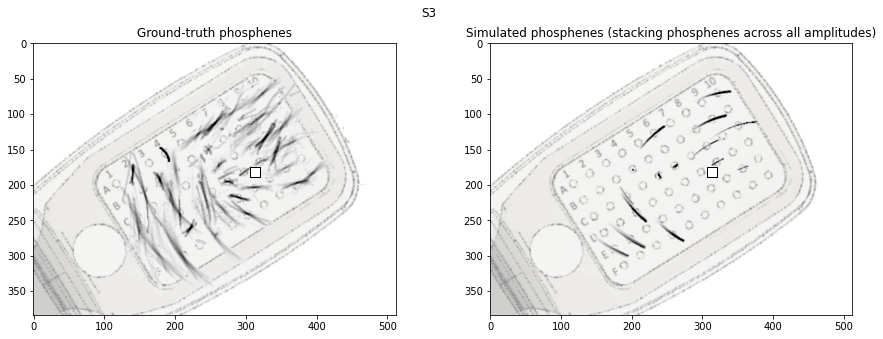

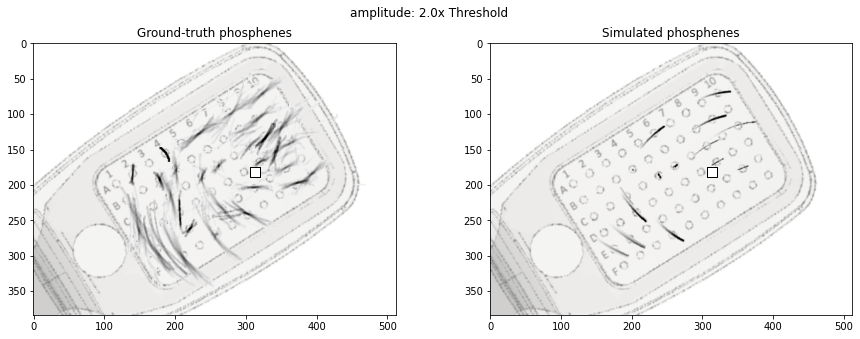

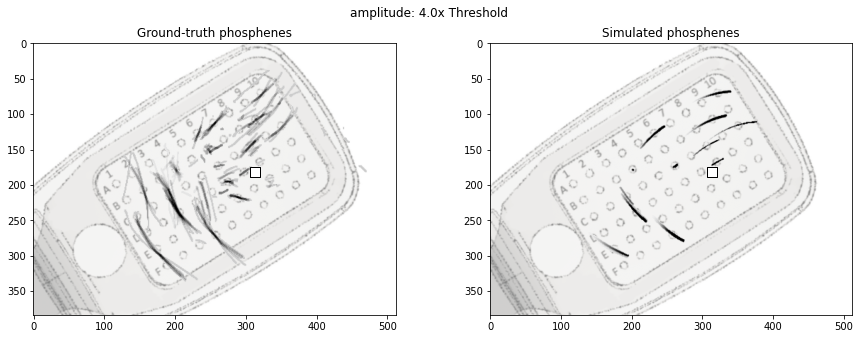

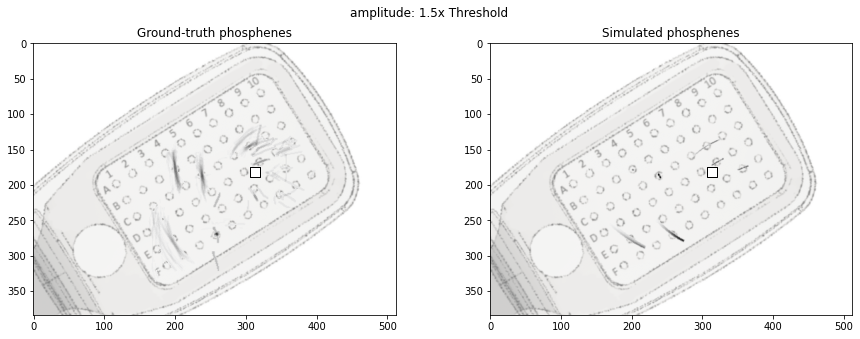

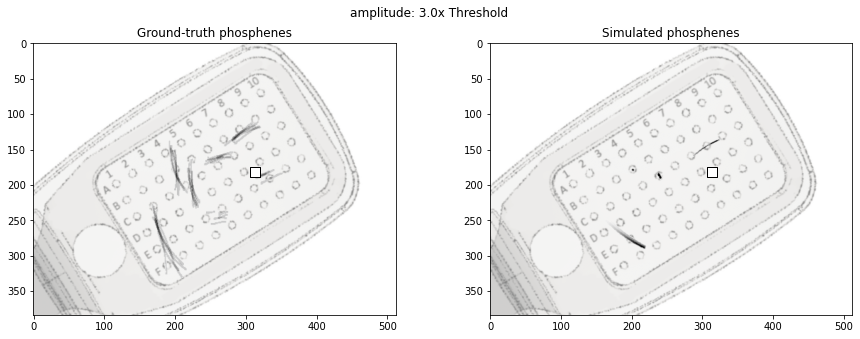

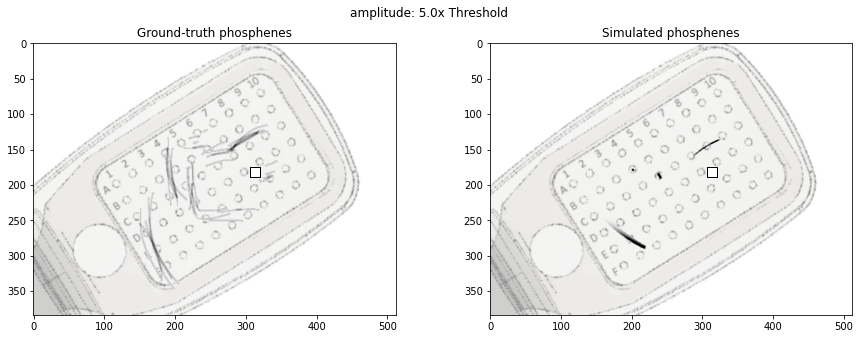

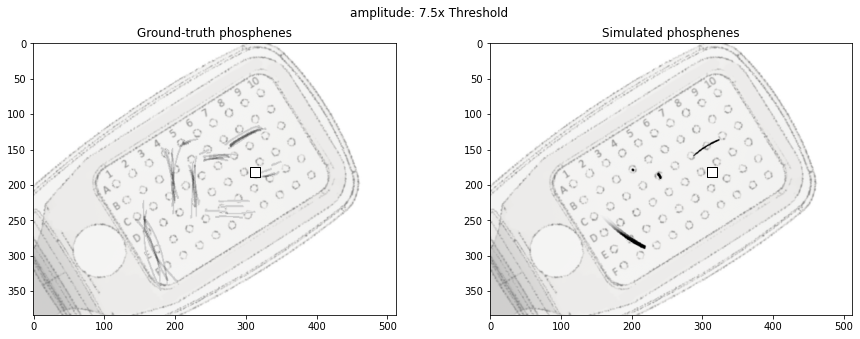

In [16]:
s3 = shapes.subject_params['51-009']
implant, model = shapes.model_from_params(s3, biphasic=False)
model.xystep=0.125

estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', "major_axis_length", "minor_axis_length"], loss_fn='r2', scale_features=False, resize=True)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=20, has_loss_function=True)

data = shapes.load_shapes("/home/yuchen/shapes/data/shapes.h5", subjects=['51-009'],stim_class=None)
data = data[data['electrode2'] == str()].reset_index(drop=True)
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

y_moments = estimator.compute_moments(y)
averaged_moments = data
averaged_moments[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = averaged_moments.groupby(['electrode1','amp1', 'freq','pdur'])['area', 'eccentricity', 'orientation'].mean()
x = averaged_moments.index.to_frame().reset_index(drop=True)

x = x[x.electrode1.isin(df.electrode)].reset_index(drop=True)

df_pred = pd.DataFrame()
for i in range(len(df)):
    electrode =  df.electrode[i]
    x_temp = x[x['electrode1']==electrode].reset_index(drop=True)
    df_temp = df[df['electrode']==electrode].reset_index(drop=True)
    
    # set estimator parameters and predict percepts for each leave-one-electrode-out cross validation group
    params = {'rho':df_temp.rho[0], 'axlambda':df_temp.axlambda[0]}
    estimator.set_params(**params)
    estimator.fit(x_temp,averaged_moments.loc[[(electrode)]])
    preds = estimator.predict(x_temp)
    df_pred = pd.concat([df_pred, preds], axis = 0)
x['pred']=df_pred.iloc[:, 0].tolist()

# construct dataframes
from pulse2percept.datasets import fetch_beyeler2019
data1 = fetch_beyeler2019(subjects='S3')
df_pred = pd.DataFrame({
    'subject':'S3',
    'image':x.pred,
    'electrode':x.electrode1
})
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
df_pred['xrange']=data1.xrange
df_pred['yrange']=data1.yrange
df_pred['amp'] = x.amp1
df_pred['freq']=x.freq
# for i in range(len(df_pred)):
#     df_pred['image'][i] = resize(center_image(preds[i] > (preds[i].max() - preds[i].min()) * 0.1 + preds[i].min()), y[i].shape)
    
df_actual = data[['subject','image','electrode1','amp1','freq']]
df_actual['subject'] = 'S3'
df_actual['xrange']=[(-30.0, 30.0)]*len(df_actual)
df_actual['yrange']=[(-22.5, 22.5)]*len(df_actual)
df_actual=df_actual.rename(columns={"electrode1": "electrode",'amp1':'amp'})


fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
argus = ArgusII(x=-1203, y = 280, rot=-35, eye='RE')
plot_argus_phosphenes(df_actual, argus, ax=ax_data,scale=1)
plot_argus_phosphenes(df_pred, argus,ax=ax_sim,scale=1)
ax_data.set_title('Ground-truth phosphenes')
ax_sim.set_title('Simulated phosphenes (stacking phosphenes across all amplitudes)')
fig.suptitle('S3')

for i in range(len(x.amp1.unique())):
    amp_temp=x.amp1.unique()[i]
    df_actual_temp=df_actual[df_actual['amp']==amp_temp]
    df_pred_temp=df_pred[df_pred['amp']==amp_temp]
    fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
    plot_argus_phosphenes(df_actual_temp, argus, ax=ax_data,scale=1)
    plot_argus_phosphenes(df_pred_temp, argus,ax=ax_sim,scale=1)
    ax_data.set_title('Ground-truth phosphenes')
    ax_sim.set_title('Simulated phosphenes')
    fig.suptitle('amplitude: ' + str(amp_temp) + 'x Threshold')

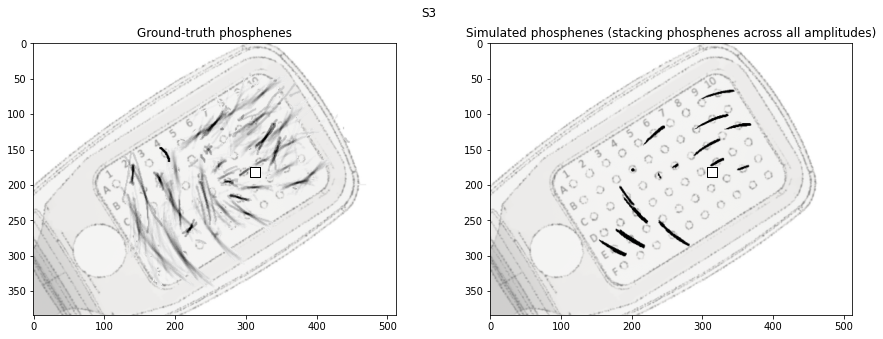

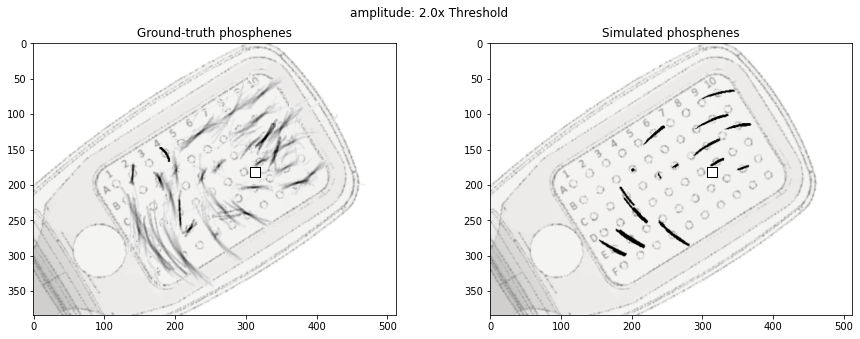

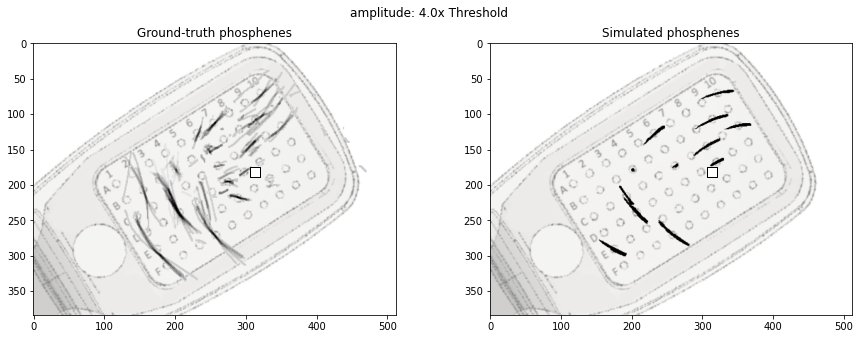

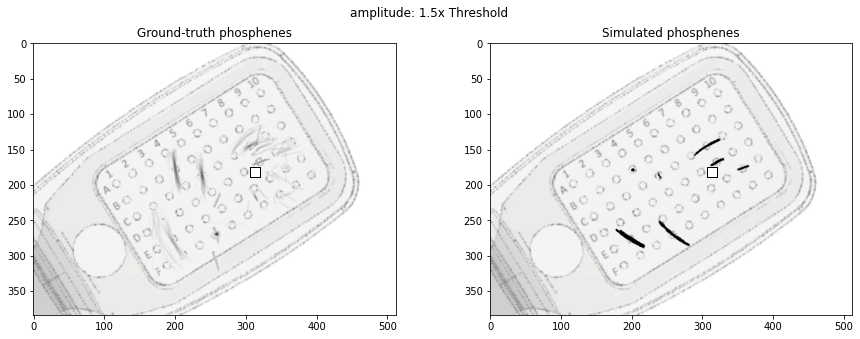

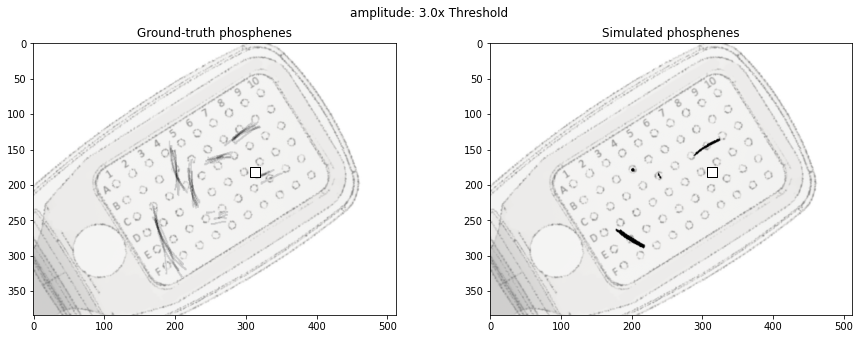

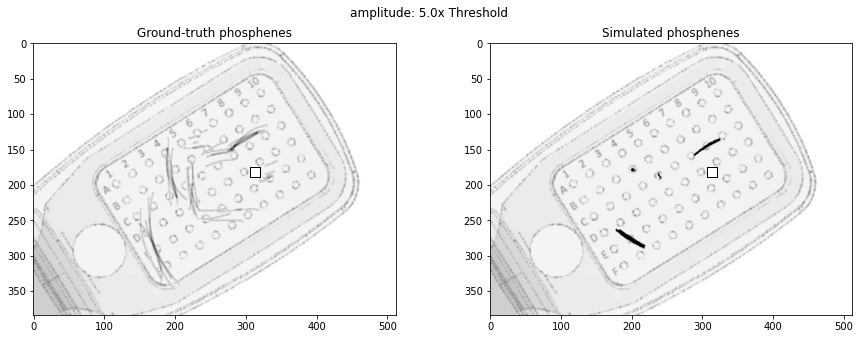

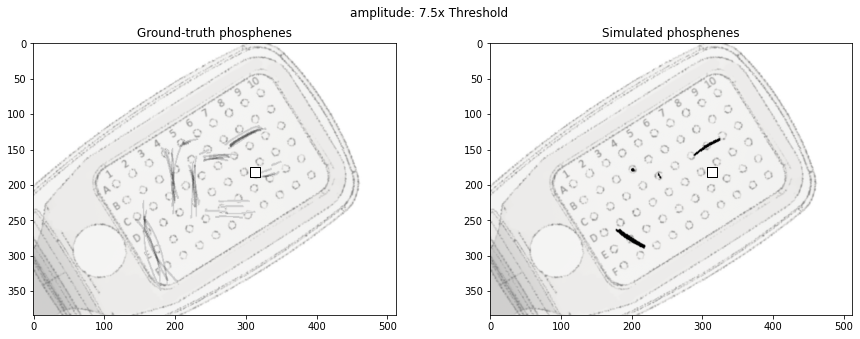

In [136]:
# construct dataframes
from pulse2percept.datasets import fetch_beyeler2019
data1 = fetch_beyeler2019(subjects='S3')
df_pred = pd.DataFrame({
    'subject':'S3',
    'image':x.pred,
    'electrode':x.electrode1
})
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
df_pred['xrange']=data1.xrange
df_pred['yrange']=data1.yrange
df_pred['amp'] = x.amp1
df_pred['freq']=x.freq
for i in range(len(df_pred)):
    df_pred['image'][i] = resize(center_image(x.pred[i] > (x.pred[i].max() - x.pred[i].min()) * 0.1 + x.pred[i].min()), y[i].shape)
    
df_actual = data[['subject','image','electrode1','amp1','freq']]
df_actual['subject'] = 'S3'
df_actual['xrange']=[(-30.0, 30.0)]*len(df_actual)
df_actual['yrange']=[(-22.5, 22.5)]*len(df_actual)
df_actual=df_actual.rename(columns={"electrode1": "electrode",'amp1':'amp'})


fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
argus = ArgusII(x=-1203, y = 280, rot=-35, eye='RE')
plot_argus_phosphenes(df_actual, argus, ax=ax_data,scale=1)
plot_argus_phosphenes(df_pred, argus,ax=ax_sim,scale=1)
ax_data.set_title('Ground-truth phosphenes')
ax_sim.set_title('Simulated phosphenes (stacking phosphenes across all amplitudes)')
fig.suptitle('S3')

for i in range(len(x.amp1.unique())):
    amp_temp=x.amp1.unique()[i]
    df_actual_temp=df_actual[df_actual['amp']==amp_temp]
    df_pred_temp=df_pred[df_pred['amp']==amp_temp]
    fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
    plot_argus_phosphenes(df_actual_temp, argus, ax=ax_data,scale=1)
    plot_argus_phosphenes(df_pred_temp, argus,ax=ax_sim,scale=1)
    ax_data.set_title('Ground-truth phosphenes')
    ax_sim.set_title('Simulated phosphenes')
    fig.suptitle('amplitude: ' + str(amp_temp) + 'x Threshold')

In [17]:
df = pd.read_csv('/home/yuchen/shapes/estimator05xystep/biphasic.csv')
df = df[(df['subject'] == 's4') & ~df['test_orientation'].isna()]
df = df.sort_values(df.columns[0]).reset_index(drop=True)
df

electrode         rho     axlambda  train_combined  train_area  \
0         A1  282.772933   785.192122        3.340890    1.048282   
1        A10  242.584896  1411.308726        3.362926    1.029710   
2         A5  191.628093  1571.944509        3.186446    1.003674   
3         A7  219.411493  1086.371359        3.348328    1.054188   
4         A8  231.391078  1327.100237        3.332415    1.049913   
5         B7  205.634465  1197.344944        3.349374    1.065781   
6         B9  227.404737  1272.153621        3.356020    1.062276   
7        C10  223.100807  1442.157976        3.340973    1.042355   
8         D7  213.874932  1685.848374        3.433713    1.080117   
9         D8  226.917226  1261.112913        3.414947    1.068564   
10        E1  251.505102  1115.969067        3.348723    1.036676   
11       E10  229.702641  1310.106601        3.375421    1.073747   
12        E3  212.066862  1429.230087        3.359366    1.056744   
13        E5  227.524205  1150.478886        3.367266    1.065486   
14        E6  237.360632  1174.588199        3.359130    1.050320   
15        E9  220.378785  1180.069128        3.388331    1.051979   
16       F10  247.210913   838.272840        3.373396    1.018929   
17        F7  224.768373  1360.773477        3.341570    1.079458   
18        F8  243.687666   963.390771        3.365964    1.054304   
19        F9  224.383825  1295.778239        3.340545    1.053062   

    train_MSE_major_axis_length  train_MSE_minor_axis_length  test_combined  \
0                      1.292327                     1.000281   2.957449e+05   
1                      1.338078                     0.995137   1.434855e+08   
2                      1.203359                     0.979413   1.909235e+01   
3                      1.308032                     0.986107   2.521871e+01   
4                      1.291961                     0.990541   4.165032e+01   
5                      1.289871                     0.993722   4.107521e+01   
6                      1.300624                     0.993121   1.844129e+01   
7                      1.300345                     0.998273   3.366204e+01   
8                      1.350199                     1.003398   4.175064e+03   
9                      1.339068                     1.007316   2.682366e+02   
10                     1.323834                     0.988213   2.033864e+02   
11                     1.297706                     1.003969   2.580457e+01   
12                     1.288656                     1.013967   1.424778e+03   
13                     1.306540                     0.995241   2.149971e+01   
14                     1.313132                     0.995678   1.537208e+06   
15                     1.330682                     1.005669   3.124726e+01   
16                     1.304767                     1.049701   2.635063e+01   
17                     1.264061                     0.998051   1.637330e+01   
18                     1.303993                     1.007666   7.491853e+01   
19                     1.283942                     1.003541   3.122764e+02   

      test_M00     test_M02  ...      test_M22   test_area  test_eccentricity  \
0    11.336093     1.261855  ...     83.790010   11.336093       6.079950e+02   
1    62.158061  1142.221640  ...  35883.071181   57.072743       1.433616e+08   
2     1.501383     1.322341  ...      1.199722    1.501383       1.110232e+00   
3     1.277179     2.116288  ...      2.012465    1.277179       1.630268e+00   
4    12.526309     1.372724  ...      1.516516   12.266938       1.014477e+00   
5     2.556745     1.460939  ...      1.500347    2.543562       1.204139e+01   
6     1.027366     1.548807  ...      1.493400    1.027366       2.218855e+00   
7     6.698772     1.001532  ...      1.334010    6.698772       1.176272e+00   
8   298.029368  1223.923302  ...    961.662789  298.029368       2.595557e+01   
9    39.434437     3.489995  ...      2.066991   37.886063       4.642617e+00   
10

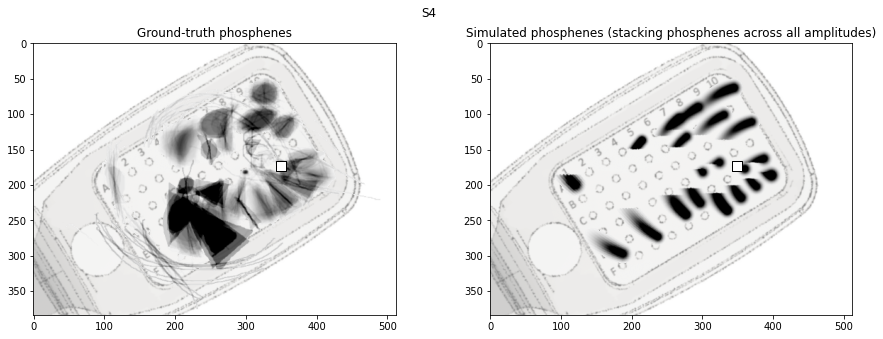

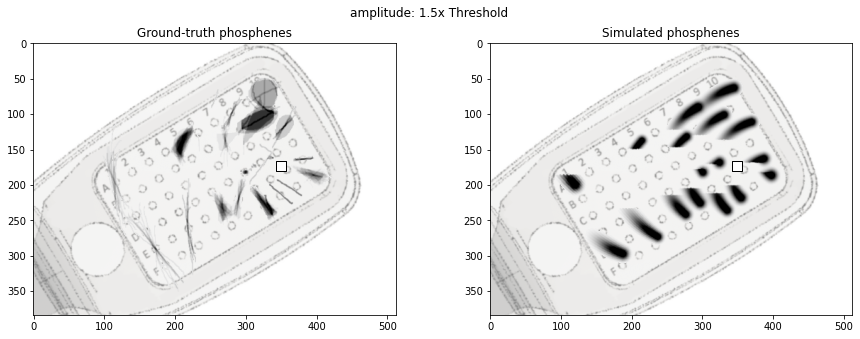

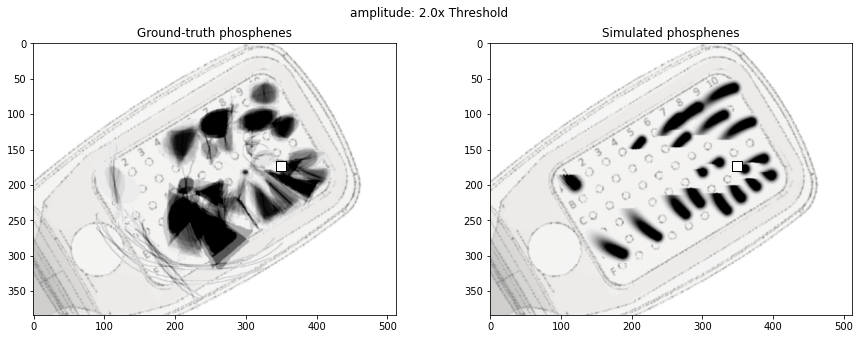

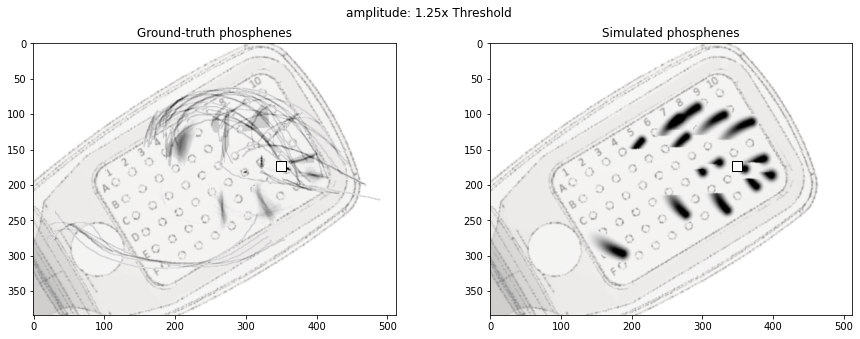

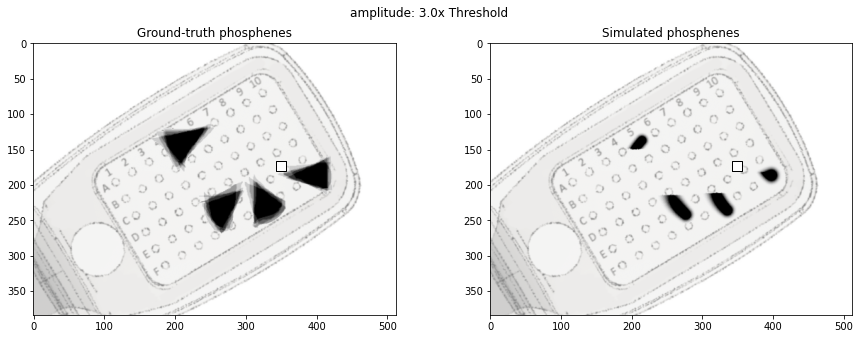

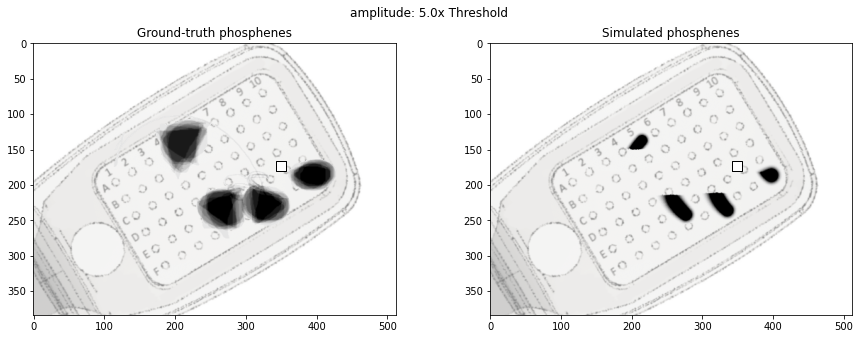

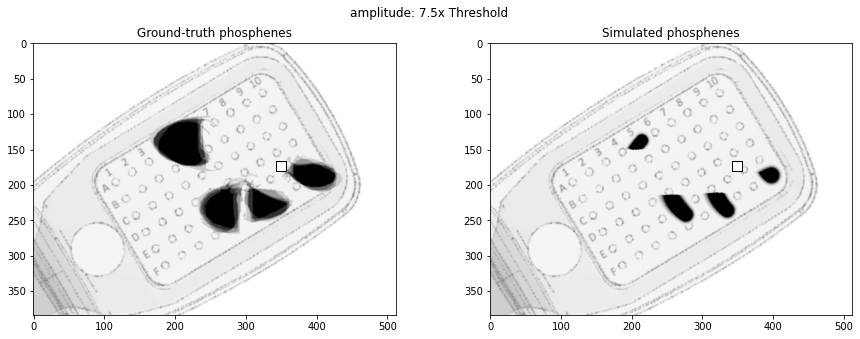

In [19]:
s4 = shapes.subject_params['52-001']
implant, model = shapes.model_from_params(s4, biphasic=False)
model.xystep=0.125

estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', "major_axis_length", "minor_axis_length"], loss_fn='r2', scale_features=False, resize=True)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=20, has_loss_function=True)

data = shapes.load_shapes("/home/yuchen/shapes/data/shapes.h5", subjects=['52-001'],stim_class=None)
data = data[data['electrode2'] == str()].reset_index(drop=True)
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

y_moments = estimator.compute_moments(y)
averaged_moments = data
averaged_moments[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = averaged_moments.groupby(['electrode1','amp1', 'freq','pdur'])['area', 'eccentricity', 'orientation'].mean()
x = averaged_moments.index.to_frame().reset_index(drop=True)

x = x[x.electrode1.isin(df.electrode)].reset_index(drop=True)

df_pred = pd.DataFrame()
for i in range(len(df)):
    electrode =  df.electrode[i]
    x_temp = x[x['electrode1']==electrode].reset_index(drop=True)
    df_temp = df[df['electrode']==electrode].reset_index(drop=True)
    
    # set estimator parameters and predict percepts for each leave-one-electrode-out cross validation group
    params = {'rho':df_temp.rho[0], 'axlambda':df_temp.axlambda[0]}
    estimator.set_params(**params)
    estimator.fit(x_temp,averaged_moments.loc[[(electrode)]])
    preds = estimator.predict(x_temp)
    df_pred = pd.concat([df_pred, preds], axis = 0)
x['pred']=df_pred.iloc[:, 0].tolist()

# construct dataframes
from pulse2percept.datasets import fetch_beyeler2019
data1 = fetch_beyeler2019(subjects='S4')
df_pred = pd.DataFrame({
    'subject':'S4',
    'image':x.pred,
    'electrode':x.electrode1
})
df_pred['xrange']=data1.xrange
df_pred['yrange']=data1.yrange
df_pred['amp'] = x.amp1
df_pred['freq']=x.freq
# for i in range(len(df_pred)):
#     df_pred['image'][i] = resize(center_image(preds[i] > (preds[i].max() - preds[i].min()) * 0.1 + preds[i].min()), y[i].shape)
    
df_actual = data[['subject','image','electrode1','amp1','freq']]
df_actual['subject'] = 'S4'
df_actual['xrange']=[(-30.0, 30.0)]*len(df_actual)
df_actual['yrange']=[(-22.5, 22.5)]*len(df_actual)
df_actual=df_actual.rename(columns={"electrode1": "electrode",'amp1':'amp'})

# plot
fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
argus = ArgusII(x=-1945, y = 469, rot=-34, eye='RE')
plot_argus_phosphenes(df_actual, argus, ax=ax_data,scale=0.7)
plot_argus_phosphenes(df_pred, argus,ax=ax_sim,scale=0.7)
ax_data.set_title('Ground-truth phosphenes')
ax_sim.set_title('Simulated phosphenes (stacking phosphenes across all amplitudes)')
fig.suptitle('S4')

for i in range(len(x.amp1.unique())):
    amp_temp=x.amp1.unique()[i]
    df_actual_temp=df_actual[df_actual['amp']==amp_temp]
    df_pred_temp=df_pred[df_pred['amp']==amp_temp]
    fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
    plot_argus_phosphenes(df_actual_temp, argus, ax=ax_data,scale=0.7)
    plot_argus_phosphenes(df_pred_temp, argus,ax=ax_sim,scale=0.7)
    ax_data.set_title('Ground-truth phosphenes')
    ax_sim.set_title('Simulated phosphenes')
    fig.suptitle('amplitude: ' + str(amp_temp) + 'x Threshold')

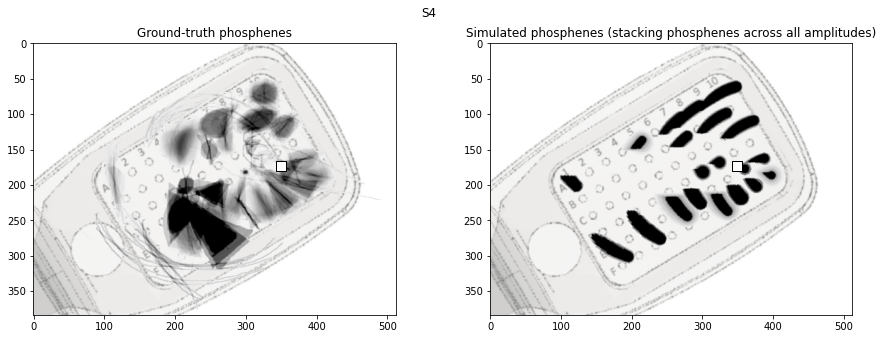

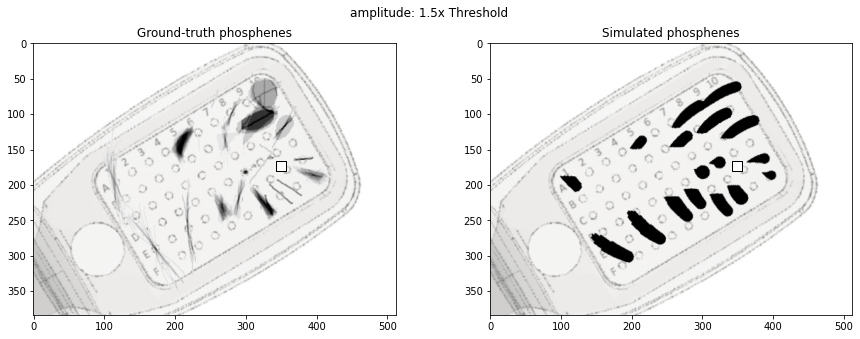

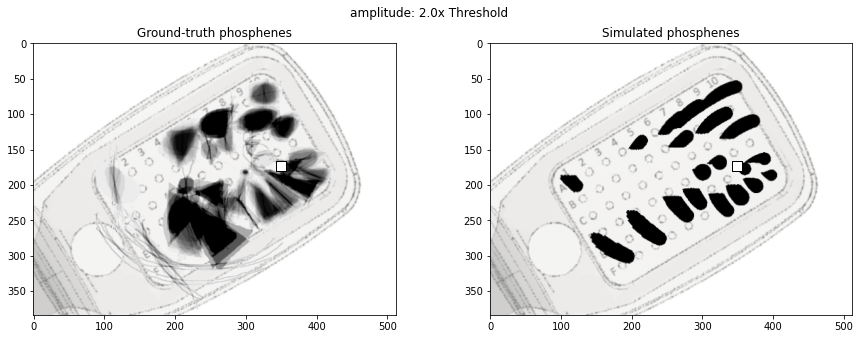

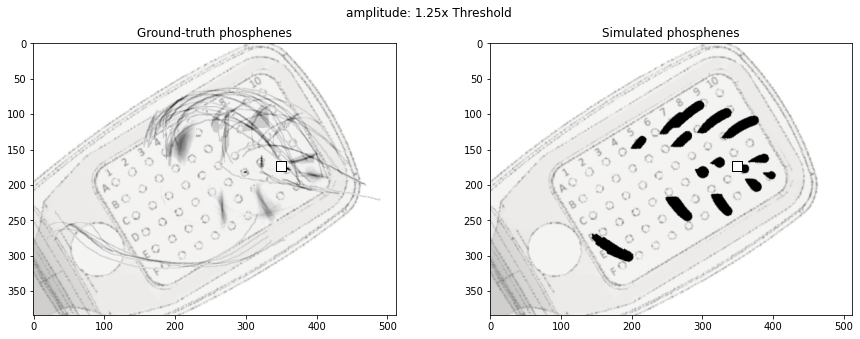

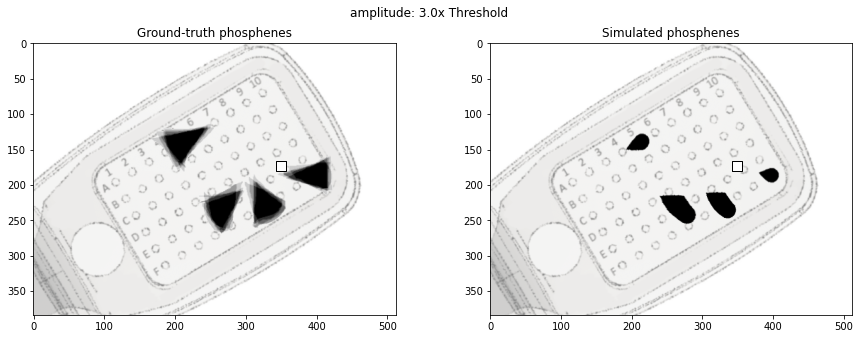

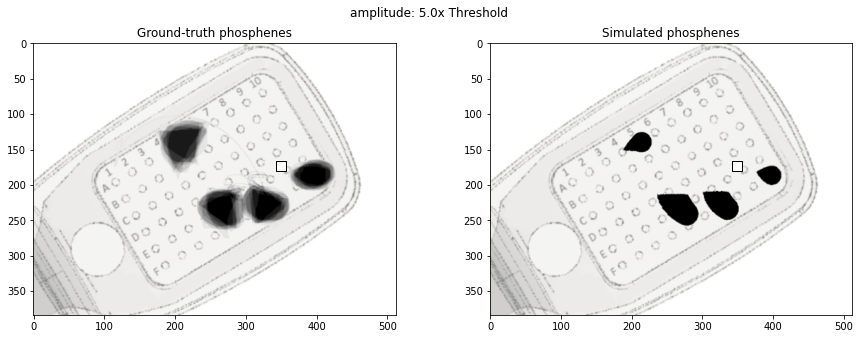

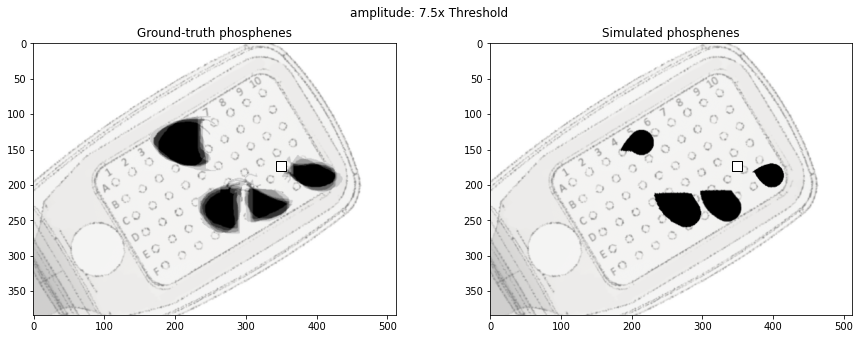

In [178]:

# construct dataframes
from pulse2percept.datasets import fetch_beyeler2019
data1 = fetch_beyeler2019(subjects='S4')
df_pred = pd.DataFrame({
    'subject':'S4',
    'image':x.pred,
    'electrode':x.electrode1
})
df_pred['xrange']=data1.xrange
df_pred['yrange']=data1.yrange
df_pred['amp'] = x.amp1
df_pred['freq']=x.freq
for i in range(len(df_pred)):
    df_pred['image'][i] = resize(center_image(x.pred[i] > (x.pred[i].max() - x.pred[i].min()) * 0.1 + x.pred[i].min()), y[i].shape)
    
df_actual = data[['subject','image','electrode1','amp1','freq']]
df_actual['subject'] = 'S4'
df_actual['xrange']=[(-30.0, 30.0)]*len(df_actual)
df_actual['yrange']=[(-22.5, 22.5)]*len(df_actual)
df_actual=df_actual.rename(columns={"electrode1": "electrode",'amp1':'amp'})

# plot
fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
argus = ArgusII(x=-1945, y = 469, rot=-34, eye='RE')
plot_argus_phosphenes(df_actual, argus, ax=ax_data,scale=0.7)
plot_argus_phosphenes(df_pred, argus,ax=ax_sim,scale=0.7)
ax_data.set_title('Ground-truth phosphenes')
ax_sim.set_title('Simulated phosphenes (stacking phosphenes across all amplitudes)')
fig.suptitle('S4')

for i in range(len(x.amp1.unique())):
    amp_temp=x.amp1.unique()[i]
    df_actual_temp=df_actual[df_actual['amp']==amp_temp]
    df_pred_temp=df_pred[df_pred['amp']==amp_temp]
    fig, (ax_data, ax_sim) = plt.subplots(ncols=2, figsize=(15, 5))
    plot_argus_phosphenes(df_actual_temp, argus, ax=ax_data,scale=0.7)
    plot_argus_phosphenes(df_pred_temp, argus,ax=ax_sim,scale=0.7)
    ax_data.set_title('Ground-truth phosphenes')
    ax_sim.set_title('Simulated phosphenes')
    fig.suptitle('amplitude: ' + str(amp_temp) + 'x Threshold')